In [ ]:
#!pip install pandas numpy matplotlib seaborn sklearn pyod

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
data = pd.read_csv('inflation_world_historic.csv')

# Exploratory Data Analysis (EDA)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            70 non-null     float64
 5   1961            72 non-null     float64
 6   1962            74 non-null     float64
 7   1963            75 non-null     float64
 8   1964            79 non-null     float64
 9   1965            86 non-null     float64
 10  1966            93 non-null     float64
 11  1967            100 non-null    float64
 12  1968            101 non-null    float64
 13  1969            102 non-null    float64
 14  1970            107 non-null    float64
 15  1971            111 non-null    float64
 16  1972            114 non-null    float64
 17  1973            117 non-null    flo

In [4]:
# compute the mean value of all numeric columns in data
world_yearly_median = data.select_dtypes(include=np.number).median()
world_median_data = pd.DataFrame(world_yearly_median[:-1])
world_median_data

,0
1960,1.945749
1961,2.102977
1962,2.669962
1963,2.876322
1964,3.328408
...,...
2017,2.432488
2018,2.534454
2019,2.216776
2020,2.002412


In [5]:
# reset index and name columns
world_median_data.reset_index(inplace=True)
world_median_data.columns = ['year', 'median']


In [6]:
world_median_data.describe()

,median
count,62.000000
mean,5.978251
std,3.562202
min,1.548692
25%,3.187885
50%,4.452406
75%,8.948548
max,17.104530


In [7]:
percentile_95 = np.percentile(world_median_data['median'], 95, method='median_unbiased')
percentile_5 = np.percentile(world_median_data['median'], 5, method='median_unbiased')

greater_than_95 = (world_median_data[['median']] > percentile_95)
smaller_than_5 = (world_median_data[['median']] < percentile_5)

# create column named colors to store the color of each point based on the condition above 
world_median_data['colors'] = np.where(greater_than_95,'r', np.where(smaller_than_5,'r','b'))

world_median_data

,year,median,colors
0,1960,1.945749,r
1,1961,2.102977,b
2,1962,2.669962,b
3,1963,2.876322,b
4,1964,3.328408,b
...,...,...,...
57,2017,2.432488,b
58,2018,2.534454,b
59,2019,2.216776,b
60,2020,2.002412,b


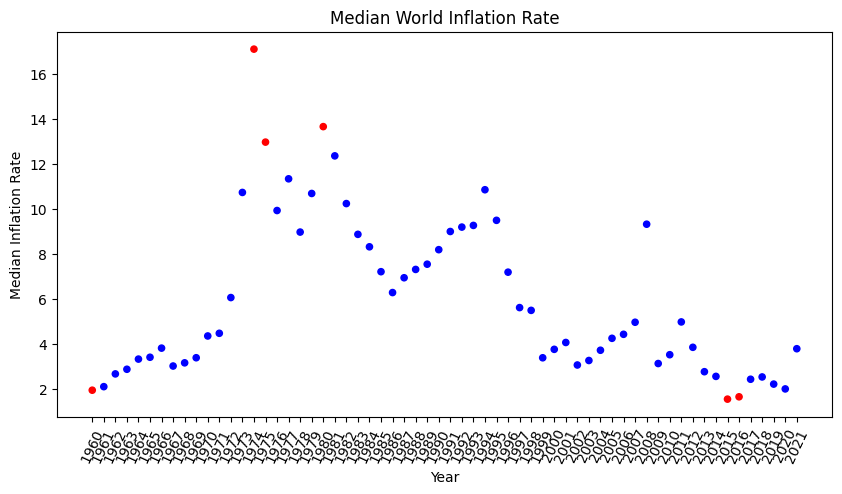

In [8]:
# plot scatter plot of the data with colors based on colors column
ax = world_median_data.plot.scatter(x='year', 
                               y='median', 
                               c=world_median_data['colors'].apply(lambda x: dict(r='red', b='blue')[x]), 
                               figsize=(10, 5),
                               title='Median World Inflation Rate',
                               xlabel='Year',
                               ylabel='Median Inflation Rate')

plt.xticks(rotation=65);

# Benchmark Linear Regression model 

In [9]:
from sklearn.linear_model import LinearRegression

LinearRegression_model = LinearRegression()
LinearRegression_model.fit(world_median_data[['year']], world_median_data[['median']])

LinearRegression()

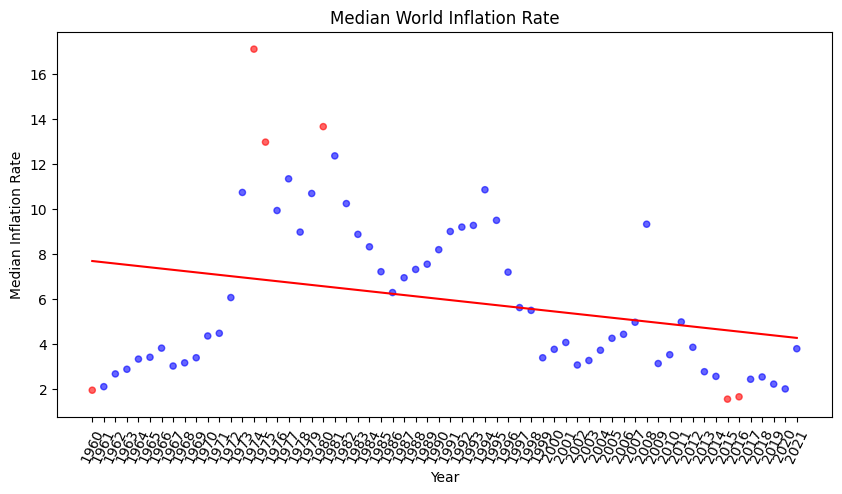

In [10]:
# How would a benchmark linear regression model perform?
ax = world_median_data.plot.scatter(x='year', y='median', 
                            c=world_median_data['colors'].apply(lambda x: dict(r='red', b='blue')[x]), 
                            alpha=.6, figsize=(10, 5),
                            title='Median World Inflation Rate',
                            xlabel='Year', ylabel='Median Inflation Rate')

reg_prediction = LinearRegression_model.predict(world_median_data[['year']])
ax.plot(world_median_data['year'], reg_prediction, c='r')
plt.xticks(rotation=65);

# Isolation Forest

In [11]:
from sklearn.ensemble import IsolationForest

model_IF = IsolationForest(contamination=float(.05))

In [12]:
model_IF.fit(world_median_data[['median']])
world_median_data['IF_anomaly_scores'] = model_IF.decision_function(world_median_data[['median']])
world_median_data['IF_anomaly'] = model_IF.predict(world_median_data[['median']])
world_median_data.head()

c:\Users\Bonoc\anaconda3\envs\anomaly_detection\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,year,median,colors,IF_anomaly_scores,IF_anomaly
0,1960,1.945749,r,0.075006,1
1,1961,2.102977,b,0.101231,1
2,1962,2.669962,b,0.147400,1
3,1963,2.876322,b,0.149380,1
4,1964,3.328408,b,0.185602,1


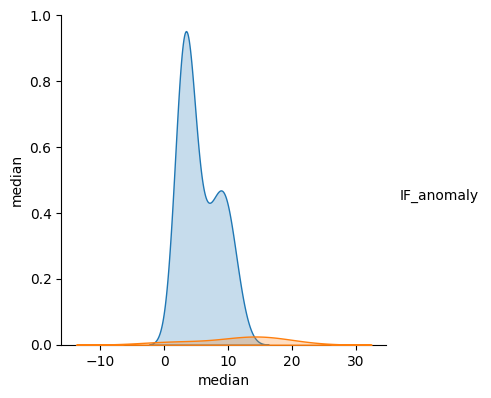

In [13]:
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(world_median_data, 
             vars=['median'], 
             hue='IF_anomaly', 
             palette=palette,
             height=4);

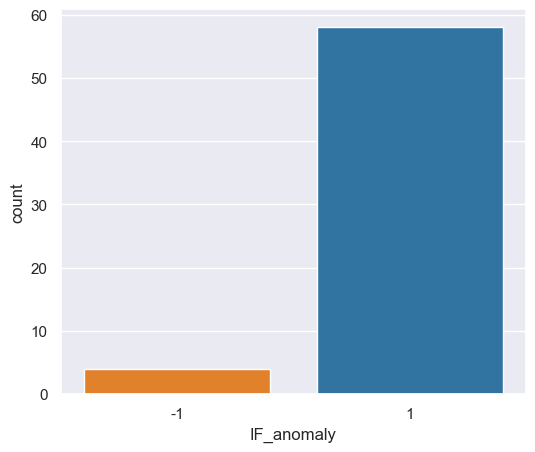

In [14]:
# phow many anomalies were detected by isolation forest?
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(6, 5)})
sns.countplot(x='IF_anomaly', 
              data=world_median_data, 
              palette=palette);

# Local Outlier Factor

In [15]:
from sklearn.neighbors import LocalOutlierFactor 

# note how predictions changes when we change the contamination and/or n_neighbors parameters
model_LOF = LocalOutlierFactor(n_neighbors=10)

In [16]:
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).

LOF_predictions = model_LOF.fit_predict(world_median_data[['median']])
n_errors = (LOF_predictions != 1).sum()
model_LOF_scores = model_LOF.negative_outlier_factor_

In [17]:
world_median_data['LOF_anomaly_scores'] = model_LOF_scores
world_median_data['LOF_anomaly'] = LOF_predictions
world_median_data.describe()

,median,IF_anomaly_scores,IF_anomaly,LOF_anomaly_scores,LOF_anomaly
count,62.000000,62.000000,62.000000,62.000000,62.000000
mean,5.978251,0.114770,0.870968,-1.164030,0.870968
std,3.562202,0.066912,0.495351,0.350619,0.495351
min,1.548692,-0.194241,-1.000000,-3.366209,-1.000000
25%,3.187885,0.083706,1.000000,-1.188285,1.000000
50%,4.452406,0.122599,1.000000,-1.067966,1.000000
75%,8.948548,0.154132,1.000000,-1.006020,1.000000
max,17.104530,0.192917,1.000000,-0.930906,1.000000


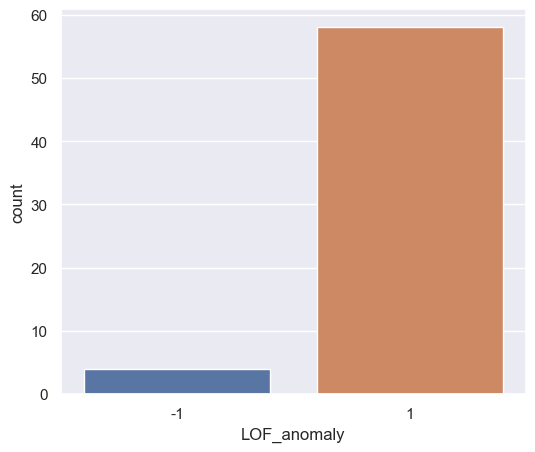

In [18]:
# phow many anomalies were detected by Local Outlier Factor?
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(6, 5)})
sns.countplot(x='LOF_anomaly', 
              data=world_median_data);

# Model Visual Comparison

C:\Users\Bonoc\AppData\Local\Temp\ipykernel_18240\449085869.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


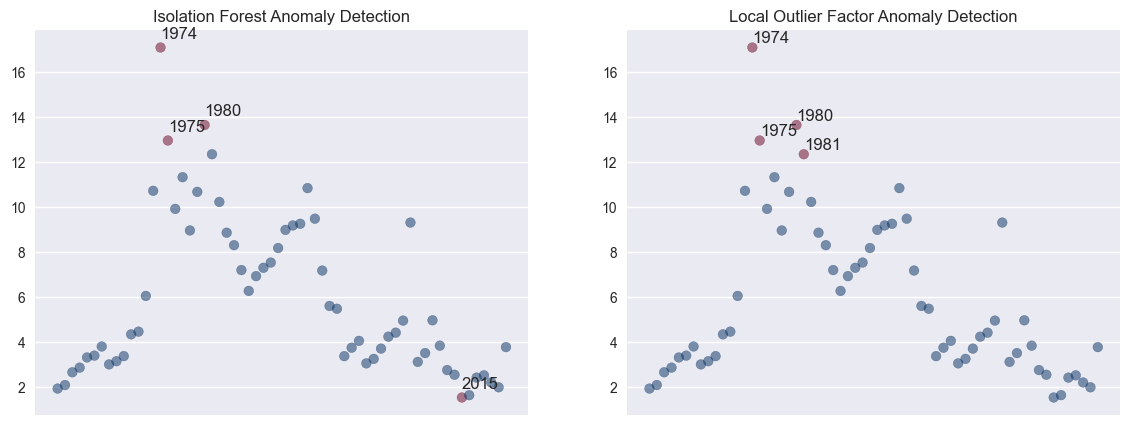

In [19]:
plt.style.use("seaborn")

# Plot two scatterplots coloring by the two different anomaly predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=False)

ax1.scatter(world_median_data['year'], 
            world_median_data['median'], 
            c=world_median_data['IF_anomaly'], 
            cmap='RdBu', 
            alpha=0.5
            )

ax1.set_title("Isolation Forest Anomaly Detection")

# label anomalies in ax1 with year value
for anomaly in world_median_data[world_median_data['IF_anomaly'] == -1]['year']:
    ax1.annotate(anomaly, 
                 xy=(anomaly, world_median_data[world_median_data['year'] == anomaly]['median']),
                 xytext=(anomaly, world_median_data[world_median_data['year'] == anomaly]['median'] + 0.4))

ax2.scatter(world_median_data['year'], 
            world_median_data['median'], 
            c=world_median_data['LOF_anomaly'], 
            cmap='RdBu', 
            alpha=0.5
            )

ax2.set_title("Local Outlier Factor Anomaly Detection")

for anomaly in world_median_data[world_median_data['LOF_anomaly'] == -1]['year']:
    ax2.annotate(anomaly, 
                 xy=(anomaly, world_median_data[world_median_data['year'] == anomaly]['median']),
                 xytext=(anomaly, world_median_data[world_median_data['year'] == anomaly]['median'] + 0.2))

# hide x axis labels from axes
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
